# `Zarr` direct access example

**Author**: Nick Forbes-Smith, Denisse Fierro Arcos  
  
This notebook demonstrates how to access a public dataset from the RIMReP collection using `zarr`. We will use the [NOAA CRW degree heating weeks](https://www.coris.noaa.gov/search/catalog/search/resource/details.page?uuid=%7BF77EF0B8-C12F-463F-B66A-CC922E50A39D%7D) dataset as an example.  
  
We will also include examples of how to make simple calculations to produce maps and timeseries.

## Loading libraries

In [2]:
# Loading and manipulating gridded multidimensional data
import xarray as xr
# Accessing S3 buckets
import s3fs

## Connecting to S3 bucket and loading dataset

In [3]:
# Path to zarr files
zarr_path = "s3://rimrep-data-public/016-023-noaa-crw/v1.zarr"

# Connection to public S3 bucket - No credentials needed
s3 = s3fs.S3FileSystem(anon = True)

# Loading zarr file
data = xr.open_dataset(s3fs.S3Map(zarr_path, s3 = s3), engine = "zarr")

#Checking result
data

<xarray.Dataset>
Dimensions:              (time: 13846, lat: 360, lon: 720)
Coordinates:
  * lat                  (lat) float32 -8.025 -8.075 -8.125 ... -25.92 -25.98
  * lon                  (lon) float32 133.0 133.1 133.1 ... 168.9 168.9 169.0
  * time                 (time) datetime64[ns] 1985-03-25T12:00:00 ... 2023-0...
Data variables:
    crs                  int16 ...
    degree_heating_week  (time, lat, lon) float32 ...
    mask                 (time, lat, lon) float32 ...
Attributes: (12/62)
    Conventions:                CF-1.6, ACDD-1.3
    NCO:                        netCDF Operators version 5.0.6 (Homepage = ht...
    acknowledgement:            NOAA Coral Reef Watch Program
    cdm_data_type:              Grid
    comment:                    This is a product of the NOAA Coral Reef Watc...
    contributor_name:           NOAA Coral Reef Watch Program
    ...                         ...
    time_coverage_duration:     P1D
    time_coverage_end:          19850326T000000Z
    time_coverage_resolution:   P1D
    time_coverage_start:        19850325T000000Z
    title:                      NOAA Coral Reef Watch Daily Global 5km Satell...
    uuid:                       24c7f597-298c-4be6-a0c2-ad97b993f60f

We can see that the above dataset has three dimensions: latitude (`lat`), longitude (`lon`) and time (`time`). This is a global dataset, with a spatial resolution of 5 km, and a daily temporal resolution between March 1985 and February 2023.  
  
We can see that there are two variables in the dataset: `degree heating week` (DHW) and `mask`. The `DHW` shows accumulated heat stress over a 12-week period, which can lead to coral bleaching and death. The scale ranges from $0^{\circ}C$ to $20^{\circ}C$-weeks. The `mask` includes the location of landmasses, grid cells covered by ice, and any grid cells with missing data.
  
We can get more information about each variable included in the dataset by calling their attributes as shown below.

In [4]:
data.mask.attrs

{'comment': 'A 2D array, in the same size as the data array in the X and Y directions, classifying land, missing, and ice pixels that are all flagged by the same missing_value (specified by the variable attribute _FillValue) in the data array(s), along with water (data) pixels.',
 'coverage_content_type': 'thematicClassification',
 'flag_meanings': 'valid-water land missing ice',
 'flag_values': [0, 1, 2, 4],
 'grid_mapping': 'crs',
 'long_name': 'pixel characteristics flag array',
 'units': 'pixel_classification'}

We can also check the metadata for the entire dataset by calling the dataset attributes as shown below.

In [5]:
data.attrs

{'Conventions': 'CF-1.6, ACDD-1.3',
 'NCO': 'netCDF Operators version 5.0.6 (Homepage = http://nco.sf.net, Code = http://github.com/nco/nco)',
 'acknowledgement': 'NOAA Coral Reef Watch Program',
 'cdm_data_type': 'Grid',
 'comment': 'This is a product of the NOAA Coral Reef Watch Daily Global 5km Satellite Coral Bleaching Heat Stress Monitoring Product Suite Version 3.1.',
 'contributor_name': 'NOAA Coral Reef Watch Program',
 'contributor_role': 'Collecting source data and deriving products; performing quality control of products; disseminating, storing, and submitting data to archive',
 'creator_email': 'coralreefwatch@noaa.gov',
 'creator_institution': 'NOAA/NESDIS/STAR Coral Reef Watch Program',
 'creator_name': 'NOAA Coral Reef Watch Program',
 'creator_type': 'group',
 'creator_url': 'https://coralreefwatch.noaa.gov/',
 'date_created': '20180301T120000Z',
 'date_issued': '20200302T152652Z',
 'date_metadata_modified': '20190405T120000Z',
 'date_modified': '20180301T120000Z',
 'ge

## Plotting data
Plotting data is easy with `xarray`, we can do it with a single line of code. Below, we will select the first time step of the `DHW` variable and plot a simple map using the `plot` method.

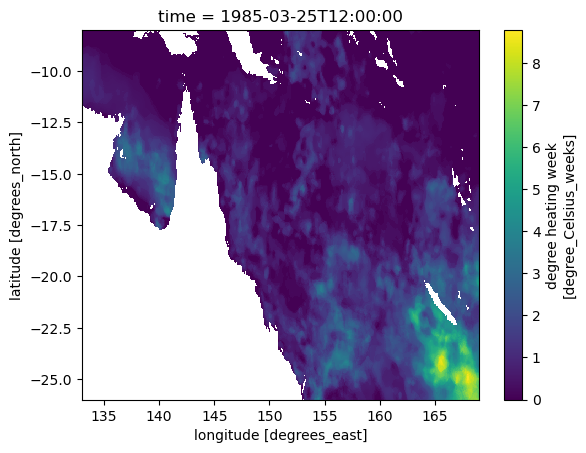

In [6]:
data.degree_heating_week.isel(time = 0).plot()

## Simple calculations using the entire grid
Below, we will create a new variable that will contain the `DHW` data for 2022. We will then calulate a monthly mean and finally we will plot the results.

In [7]:
# Subsetting data
dhw_2022 = data.degree_heating_week.sel(time = "2022")

# Checking result
dhw_2022

<xarray.DataArray 'degree_heating_week' (time: 365, lat: 360, lon: 720)>
[94608000 values with dtype=float32]
Coordinates:
  * lat      (lat) float32 -8.025 -8.075 -8.125 -8.175 ... -25.88 -25.92 -25.98
  * lon      (lon) float32 133.0 133.1 133.1 133.2 ... 168.8 168.9 168.9 169.0
  * time     (time) datetime64[ns] 2022-01-01T12:00:00 ... 2022-12-31T12:00:00
Attributes:
    coverage_content_type:  physicalMeasurement
    grid_mapping:           crs
    long_name:              degree heating week
    standard_name:          N/A
    units:                  degree_Celsius_weeks
    valid_max:              10000
    valid_min:              0

We can now group our 2022 data per calendar month and calculate the monthly mean.

In [8]:
# Calculating monthly means
dhw_monthly_2022 = dhw_2022.groupby("time.month").mean()

# Checking results
dhw_monthly_2022

<xarray.DataArray 'degree_heating_week' (month: 12, lat: 360, lon: 720)>
array([[[3.9700007 , 3.9599993 , 3.9499989 , ..., 0.        ,
         0.        , 0.        ],
        [4.29      , 4.14      , 4.120001  , ..., 0.        ,
         0.        , 0.        ],
        [4.3499994 , 4.3399982 , 4.1600018 , ..., 0.        ,
         0.        , 0.        ],
        ...,
        [       nan,        nan,        nan, ..., 0.        ,
         0.        , 0.        ],
        [       nan,        nan,        nan, ..., 0.        ,
         0.        , 0.        ],
        [       nan,        nan,        nan, ..., 0.        ,
         0.        , 0.        ]],

       [[2.6664283 , 2.6496432 , 2.6275    , ..., 0.        ,
         0.        , 0.        ],
        [2.942857  , 2.850714  , 2.7889283 , ..., 0.        ,
         0.        , 0.        ],
        [2.9878566 , 2.9675007 , 2.8671424 , ..., 0.        ,
         0.        , 0.        ],
...
        [       nan,        nan,        nan, ..., 0.        ,
         0.        , 0.        ],
        [       nan,        nan,        nan, ..., 0.        ,
         0.        , 0.        ],
        [       nan,        nan,        nan, ..., 0.        ,
         0.        , 0.        ]],

       [[5.4564514 , 5.6516137 , 5.996451  , ..., 0.        ,
         0.        , 0.        ],
        [5.705484  , 6.0358076 , 6.2387104 , ..., 0.        ,
         0.        , 0.        ],
        [6.3832245 , 6.4306464 , 6.482257  , ..., 0.        ,
         0.        , 0.        ],
        ...,
        [       nan,        nan,        nan, ..., 0.        ,
         0.        , 0.        ],
        [       nan,        nan,        nan, ..., 0.        ,
         0.        , 0.        ],
        [       nan,        nan,        nan, ..., 0.        ,
         0.        , 0.        ]]], dtype=float32)
Coordinates:
  * lat      (lat) float32 -8.025 -8.075 -8.125 -8.175 ... -25.88 -25.92 -25.98
  * lon      (lon) float32 133.0 133.1 133.1 133.2 ... 168.8 168.9 168.9 169.0
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Attributes:
    coverage_content_type:  physicalMeasurement
    grid_mapping:           crs
    long_name:              degree heating week
    standard_name:          N/A
    units:                  degree_Celsius_weeks
    valid_max:              10000
    valid_min:              0

Notice how the `time` dimension has been replaced by `month`, which includes 12 time step, one for each month of the year. We can now plot all monthly means for 2022. We use the `plot` method, specify `month` in the `col` argument, which will create a subplot for each month in our data. Finally, we use the `col_wrap` argument to specify the number of columns in our plot.

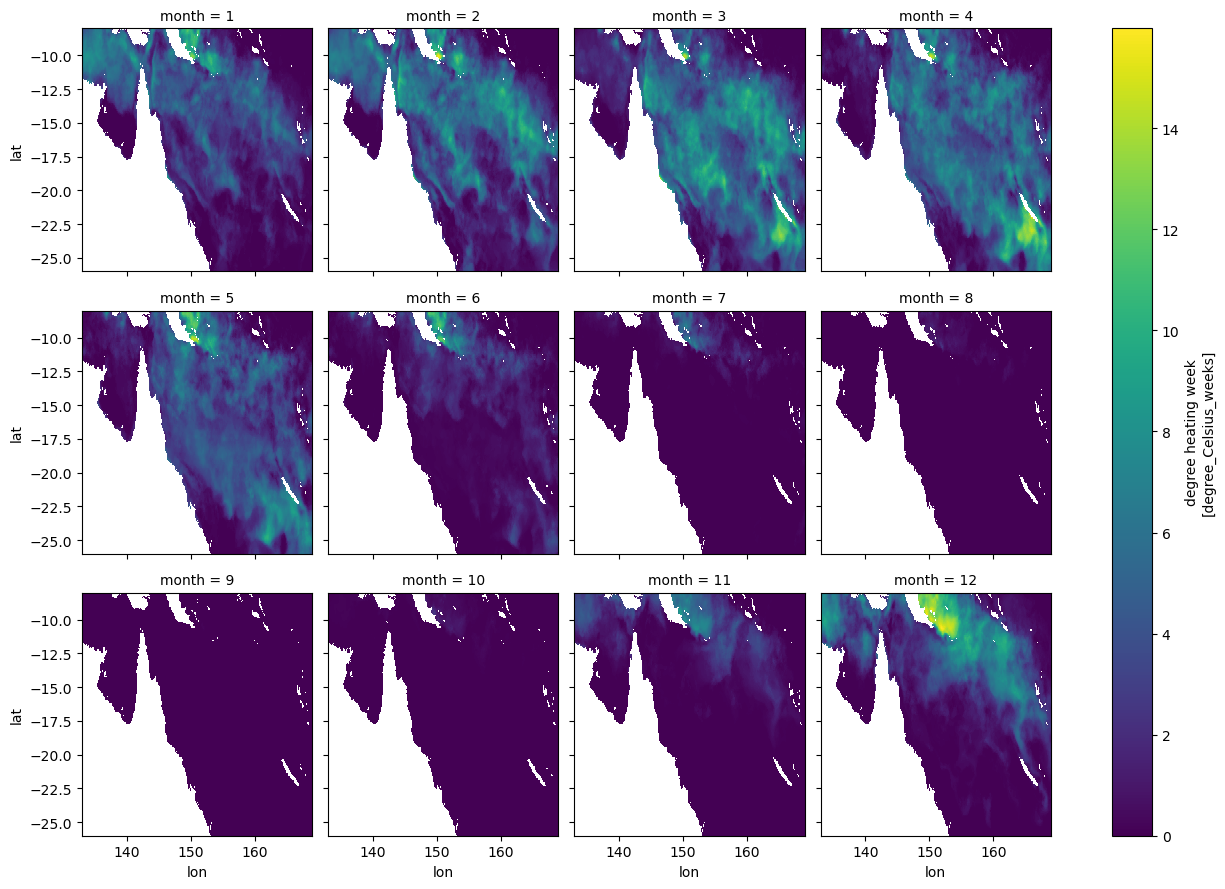

In [9]:
# Plotting monthly means
dhw_monthly_2022.plot(col = 'month', col_wrap = 4)

## Simple calculations at a single point over time
For this example, we will select a single point in the dataset and extract `DHW` values for all timesteps at that point to plot a time series. We will use the `sel` method to select the point nearest to `lat` = -20 and `lon` = 155. We will then subset the data temporally between 2020-01-01 and 2023-01-01, and plot it.  
  
We can do all this in a single line of code as shown below.

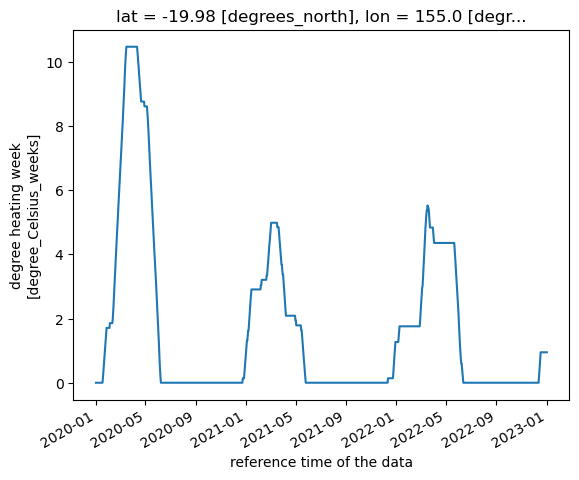

In [10]:
data.degree_heating_week.sel(lat = -20, lon = 155, method = 'nearest').\
    sel(time = slice('2020-01-01', '2023-01-01')).plot()

## Calculating time series over entire grid
We can also calculate time series for the entire grid. Below, we will show how to calculate the mean `DHW` values for the entire area of interest at each timestep between 2020 and 2022. We will then plot the results.

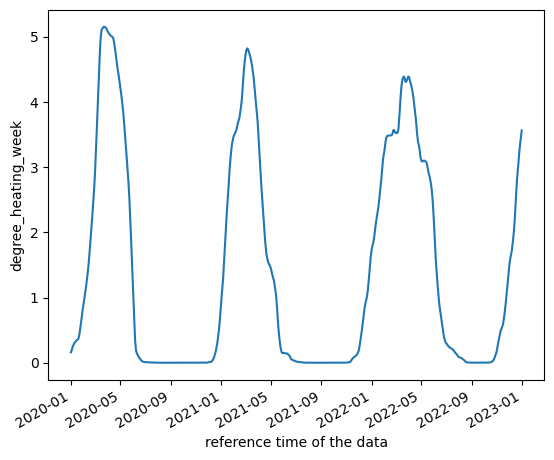

In [11]:
# Subsetting data for the period between 2020 and 2022
dhw_sub = data.degree_heating_week.sel(time = slice('2020-01-01', '2022-12-31'))

# Calculting mean at each time step and plot results
dhw_sub.mean(('lat', 'lon')).plot()

# Load Great Barrier Reefs Datasets


In [34]:
# Loading GBR reefs shapefile
import geopandas as gpd

# Path to shapefile
shp_path = gpd.read_file("../Shapefiles/Reef_marine_bioregions_of_the_Great_Barrier_Reef.shp")

shp_path

,FID,BIOREGION,SUB_REEF,SUBREEFBIO,SUBREEFLAB,DESCRIP,LOC_NAME,SHAPE_Leng,SHAPE_Area,geometry
0,1,35.0,C,78.0,RSW-M_C,Swains Mid Reefs,RSW-M Swains Mid Reefs,0.072343,0.000235,"POLYGON ((152.51489 -22.04951, 152.51596 -22.0..."
1,2,35.0,C,78.0,RSW-M_C,Swains Mid Reefs,RSW-M Swains Mid Reefs,0.109756,0.000680,"POLYGON ((152.66633 -22.08223, 152.66624 -22.0..."
2,3,35.0,C,78.0,RSW-M_C,Swains Mid Reefs,RSW-M Swains Mid Reefs,0.091652,0.000230,"POLYGON ((152.49294 -22.04667, 152.49267 -22.0..."
3,4,39.0,C,66.0,RHE_C,Strong Tidal Mid Shelf Reefs (East),RHE Strong Tidal Mid Shelf Reefs (East),0.031369,0.000077,"POLYGON ((152.07620 -22.03755, 152.07522 -22.0..."
4,5,18.0,C,43.0,RE5_C,High Tidal Fringing Reefs,RE5 High Tidal Fringing Reefs,0.036400,0.000046,"POLYGON ((150.65088 -22.02539, 150.65282 -22.0..."
...,...,...,...,...,...,...,...,...,...,...
3633,3634,7.0,A,16.0,RB1_A,Far Northern Outer Mid Shelf Reefs,RB1 Far Northern Outer Mid Shelf Reefs,0.048714,0.000131,"POLYGON ((143.75515 -11.48160, 143.75584 -11.4..."
3634,3635,14.0,A,30.0,RE1_A,Coastal Far Northern Reefs,RE1 Coastal Far Northern Reefs,0.008405,0.000004,"POLYGON ((142.82987 -11.29139, 142.82954 -11.2..."
3635,3636,2.0,None,3.0,RA1,Deltaic Reefs,RA1 Deltaic Reefs,0.007896,0.000004,"POLYGON ((144.01860 -11.28723, 144.01851 -11.2..."
3636,3637,13.0,A,28.0,RD_A,Far Northern Open Lagoon Reefs,RD Far Northern Open Lagoon Reefs,0.027589,0.000045,"POLYGON ((143.04805 -11.29158, 143.04633 -11.2..."


In [46]:

merge_reef = shp_path.dissolve(by = 'SUB_REEF')
merge_reef

,geometry,FID,BIOREGION,SUBREEFBIO,SUBREEFLAB,DESCRIP,LOC_NAME,SHAPE_Leng,SHAPE_Area
SUB_REEF,,,,,,,,,
A,"MULTIPOLYGON (((143.12747 -12.28689, 143.12729...",11,19.0,44.0,RE6_A,Incipient Reefs,RE6 Incipient Reefs,0.041145,0.000079
B,"MULTIPOLYGON (((143.69942 -14.17635, 143.69988...",7,39.0,66.0,RHE_B,Strong Tidal Mid Shelf Reefs (East),RHE Strong Tidal Mid Shelf Reefs (East),0.135228,0.000461
C,"MULTIPOLYGON (((145.53256 -16.59187, 145.53382...",1,35.0,78.0,RSW-M_C,Swains Mid Reefs,RSW-M Swains Mid Reefs,0.072343,0.000235
D,"MULTIPOLYGON (((146.07710 -17.20824, 146.07721...",478,32.0,72.0,RHL_D,Hard Line Reefs,RHL Hard Line Reefs,0.032977,0.000020
E,"MULTIPOLYGON (((145.78934 -16.02044, 145.78927...",1618,3.0,5.0,RA2_E,Outer Barrier Reefs,RA2 Outer Barrier Reefs,0.031210,0.000049


<Axes: >

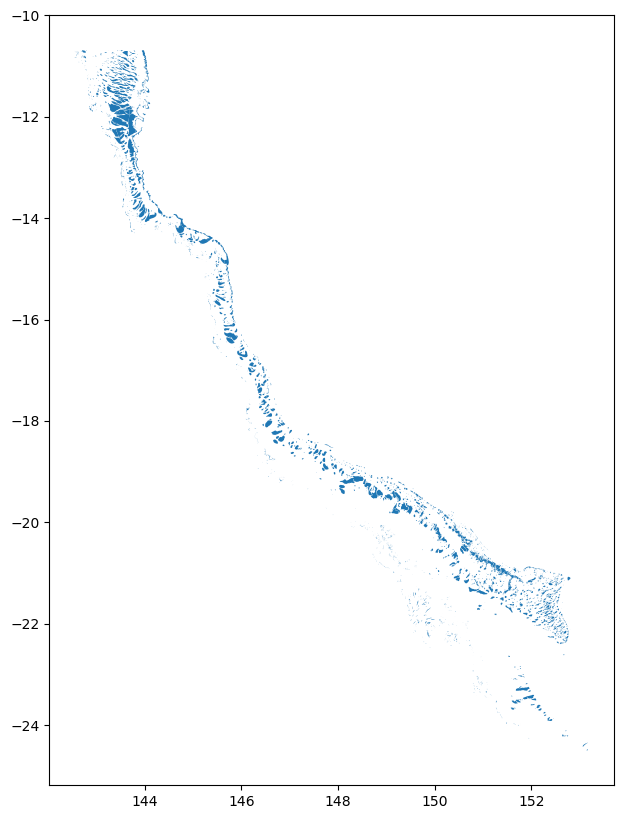

In [19]:
# plot the GRB reefs shapefile
shp_path.plot(figsize = (10, 10))

## Overlay Analysis - Reefs & SST Data
We will analyse the SST data for each of Reefs data in GBR

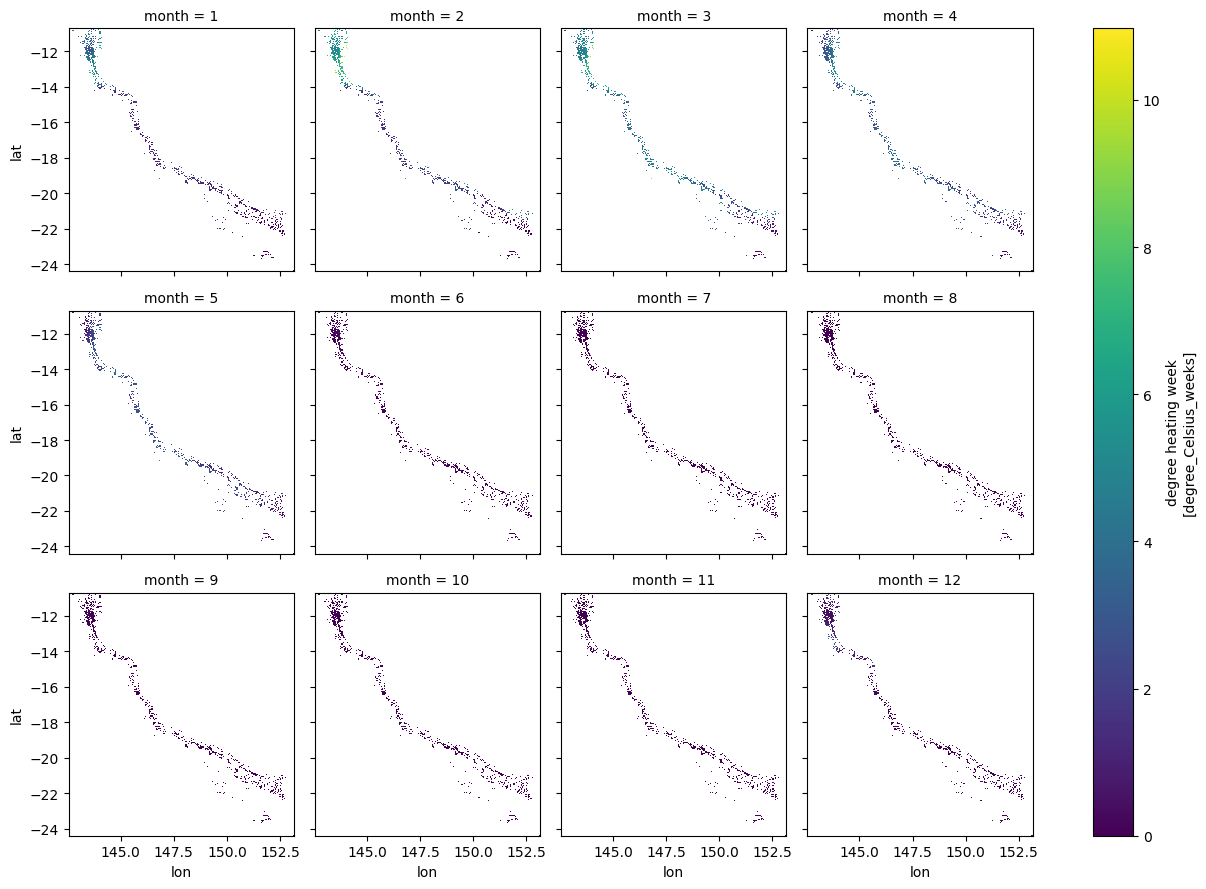

In [28]:
#load libraries
import rioxarray
import geopandas as gpd
from shapely.geometry import mapping

# Calculating each reefs for the monthly degree heating weeks (dhw_monthly_2022)
dhw_monthly_2022.rio.set_crs("epsg:4326").rio.clip(shp_path.geometry.apply(mapping)).plot(col = 'month', col_wrap = 4)

In [33]:
# Calculating each reefs for the monthly degree heating weeks (dhw_monthly_2022)
reefs_dhw_2022 = dhw_monthly_2022.rio.set_crs("epsg:4326").rio.clip(shp_path.geometry.apply(mapping)).mean(('lat', 'lon'))
reefs_dhw_2022.attrs['units'] = 'degree heating weeks'
reefs_dhw_2022.mean('month')

<xarray.DataArray 'degree_heating_week' ()>
array(1.1998651, dtype=float32)
Coordinates:
    crs      int32 0

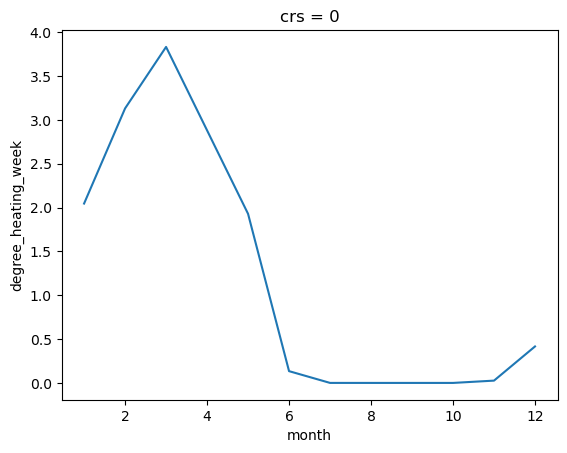

In [35]:
reefs_dhw_2022 = dhw_monthly_2022.rio.set_crs("epsg:4326").rio.clip(shp_path.geometry.apply(mapping)).mean(('lat', 'lon')).plot()

In [56]:

vars_dd = dhw_monthly_2022.rename({'lat': 'y', 'lon': 'x'})
vars_dd.rio.to_raster('dhw_monthly_2022.tif')



In [1]:
from rasterstats import zonal_stats
from osgeo import gdal

# reefs_dhw_2022_mean = zonal_stats(shp_path, '../', stats = 'mean')


In [2]:
reefs_dhw_stats = gdal.Open('dhw_monthly_2022.tif')

c:\Users\n11479035\AppData\Local\anaconda3\envs\geospatial\Lib\site-packages\osgeo\gdal.py:287: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


In [35]:
import matplotlib.pyplot as plt

<Axes: title={'center': 'band = 1, spatial_ref = 0'}, xlabel='x', ylabel='y'>

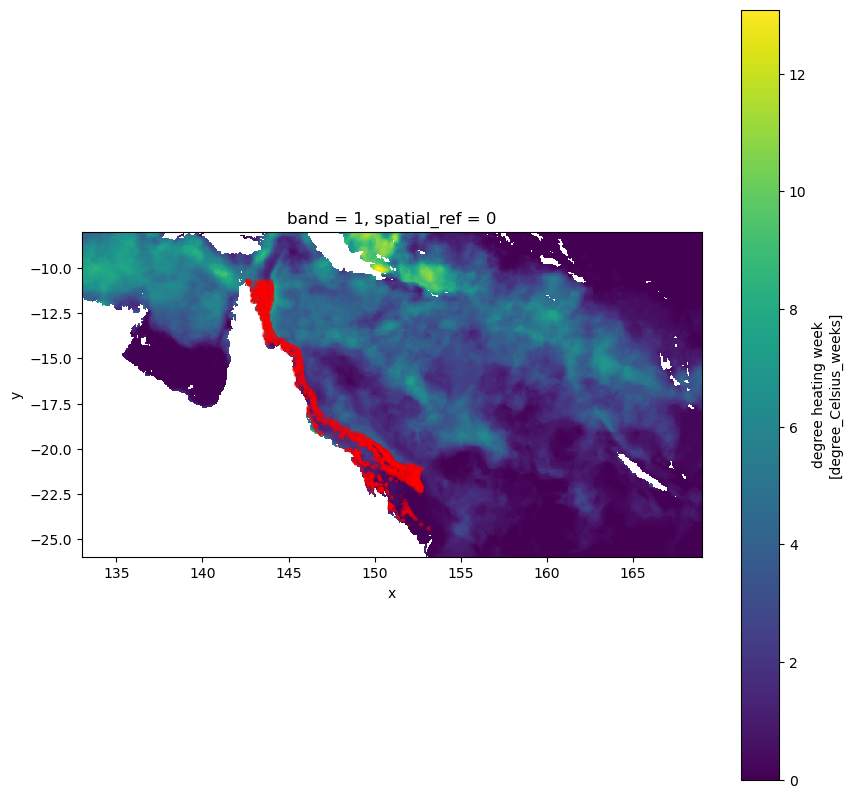

In [40]:
fig = plt.figure(figsize = (10, 10))
ax = fig.add_subplot(111)

reefs_dhw_stats.isel(band = 0).plot(ax = ax)
shp_path.plot(ax = ax, facecolor = 'none', edgecolor = 'red', linewidth = 2, alpha = 0.5)

In [51]:
# from pygeoprocessing import zonal_statistics
# from rioxarray import open_rasterio

# reefs_dhw_stats = open_rasterio('dhw_monthly_2022.tif')
reefs_dhw_2022_mean = zonal_stats(merge_reef,
            'dhw_monthly_2022.tif', stats = 'mean min max std', all_touched = True)

In [52]:
reefs_dhw_2022_mean

[{'min': 0.0,
  'max': 8.058709144592285,
  'mean': 2.294803418853852,
  'std': 1.7803213170093446},
 {'min': 0.0,
  'max': 7.617740631103516,
  'mean': 1.8113675110145415,
  'std': 1.8687745903429631},
 {'min': 0.0,
  'max': 8.367741584777832,
  'mean': 1.5157157234523608,
  'std': 1.7491109679796493},
 {'min': 0.0,
  'max': 4.168065071105957,
  'mean': 1.8196758054337412,
  'std': 0.9000344435353298},
 {'min': 0.7480644583702087,
  'max': 2.378386974334717,
  'mean': 1.1892830742730034,
  'std': 0.3372792796538221}]